In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from shutil import copyfile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import matplotlib.pyplot as plt
import torchvision
import time

In [4]:
base_dir = 'L:\\documents\\python_code\\jupyter-notebook\\ML\\dataset\\FMDataset'

output_dir = os.path.join(base_dir, 'dataset')
input_dir = os.path.join(base_dir, 'dataset_raw')

base_list = ['Training', 'Validation']
fm_list = ['male', 'female']
num_dic = {'Training': 3000, 'Validation': 500}

for i in base_list:
    out_dir = os.path.join(output_dir, i)
    os.mkdir(out_dir)
    in_dir = os.path.join(input_dir, i)
    for j in fm_list:
        out_fdir = os.path.join(out_dir, j)
        os.mkdir(out_fdir)
        in_fdir = os.path.join(in_dir, j)
        file_list = os.listdir(in_fdir)
        for k in range(num_dic[i]):
            copyfile(os.path.join(in_fdir, file_list[k]), os.path.join(out_fdir, file_list[k]))

In [10]:
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


image_datasets = {x: datasets.ImageFolder(os.path.join(output_dir, x), data_transforms[x]) for x in base_list}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in base_list}
dataset_sizes = {x: len(image_datasets[x]) for x in base_list}
class_names = image_datasets['Training'].classes

device = torch.device('cuda:0')

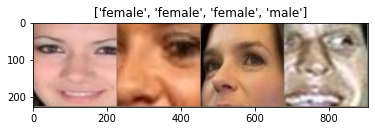

In [12]:
def imshow(inp, title=None):
    '''Imshow for Tensor'''
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# 获取一批训练数据
inputs, classes = next(iter(dataloaders['Training']))

# 批量制作网格
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['Training', 'Validation']:
            if phase == 'Training':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_correct = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'Training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_correct.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
        print()        
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

In [3]:
device = torch.device('cuda:0')
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
Training Loss: 0.6186 Acc: 0.7333
Validation Loss: 0.2035 Acc: 0.9270

Epoch 1/24
----------
Training Loss: 0.5228 Acc: 0.7858
Validation Loss: 0.2980 Acc: 0.8810

Epoch 2/24
----------
Training Loss: 0.4094 Acc: 0.8355
Validation Loss: 0.1535 Acc: 0.9470

Epoch 3/24
----------
Training Loss: 0.3283 Acc: 0.8618
Validation Loss: 0.1415 Acc: 0.9600

Epoch 4/24
----------
Training Loss: 0.2750 Acc: 0.8917
Validation Loss: 0.2820 Acc: 0.8960

Epoch 5/24
----------
Training Loss: 0.2387 Acc: 0.9078
Validation Loss: 0.1418 Acc: 0.9490

Epoch 6/24
----------
Training Loss: 0.2497 Acc: 0.9013
Validation Loss: 0.1239 Acc: 0.9620

Epoch 7/24
----------
Training Loss: 0.2144 Acc: 0.9170
Validation Loss: 0.1041 Acc: 0.9630

Epoch 8/24
----------
Training Loss: 0.2092 Acc: 0.9200
Validation Loss: 0.2668 Acc: 0.9270

Epoch 9/24
----------
Training Loss: 0.2069 Acc: 0.9203
Validation Loss: 0.1095 Acc: 0.9640

Epoch 10/24
----------
Training Loss: 0.1831 Acc: 0.9302
Validation Lo

In [13]:
torch.save(model_ft.state_dict(), 'model/FM_model.pt')

In [4]:
model_ft.load_state_dict(torch.load('model/FM_model.pt'))

<All keys matched successfully>